# Model Generation for GBIF Fungi Dataset

In [1]:
notebook_ver = "0.0.1"

## References
* [Transfer Learning with Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
* [`tf.data`: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data?hl=en)

---

## Setup

In [2]:
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_hub as hub
from keras.utils.layer_utils import count_params

from sklearn.model_selection import train_test_split
import json
import time
import datetime
import logging

# Set logging to output INFO level to standard output
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

# Set tf logging level to WARN
tf.get_logger().setLevel( 'WARN' )

AUTOTUNE = tf.data.AUTOTUNE

### Limit GPU memory allocation
[Limiting GPU Memory Growth](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth)

In [3]:
def limit_memory_growth(limit=True):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, limit)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [4]:
limit_memory_growth()

2 Physical GPUs, 2 Logical GPUs


### Multi-GPU strategy

In [5]:
# strategy = tf.distribute.MirroredStrategy( devices = [ "/gpu:0", "/gpu:1" ] )
strategy = tf.distribute.MirroredStrategy()

---

## `runs` DataFrame
Keeps track of all runs performed

In [6]:
runs_dir = '/media/data/runs'
runs_hdf = 'runs.h5'
runs_hdf_key = 'runs'

## `run` Dictionary

The `run` dictionary will keep track of this run's user-defined hyperparameters as well as generated parameters such as random seeds and file paths. This information will be saved in the `runs_hdf` specified above.

In [7]:
run = {}
# use a formatted timestamp as the run's ID
run['id'] = datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
run['notebook_ver'] = notebook_ver

In [8]:
# the path of the directory where this run's files will be stored (metadata, saved model(s), etc.)
run['path'] = os.path.join( runs_dir, str(run['id']) )
run['path']

'/media/data/runs/2023_03_19-16_34_48'

In [9]:
# Will overwrite existing run in dataframe with the same id if one exists
# - allows updating as we go
def save_run_metadata(
    run,
    index = 'id',
):
    # create df from run using json_normalize to flatten dict
    run_df = pd.json_normalize( run )
    run_df = run_df.set_index( index )

    # create runs_df if it doesn't exist
    runs_hdf_path = os.path.join( runs_dir, runs_hdf )
    if ( not os.path.isfile( runs_hdf_path ) ):
        pd.DataFrame().to_hdf( runs_hdf_path, runs_hdf_key )
    
    # read in the runs_hdf
    runs_df = pd.read_hdf(
        runs_hdf_path,
        runs_hdf_key,
    )
    
    # If a row for this run already exists, remove it
    if ( run[ index ] in runs_df.index ):
        runs_df = runs_df.drop( run[ index ] )
 
    # Add the updated data
    runs_df = pd.concat(
        [ runs_df, run_df ],
    )
    
    # save to file
    runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


In [10]:
# quick print of current run information for debug
def print_run_metadata( run ):
    print( json.dumps( run, indent = 3 ) )

In [11]:
# Make sure the run's path doesn't already exist and create it
if (os.path.exists( run['path'] )):
    logging.warn("Run path already exists!!")
    logging.warn(" Overwriting: %s" % run['path'])
else:
    os.makedirs( run['path'] )

In [12]:
print_run_metadata( run )

{
   "id": "2023_03_19-16_34_48",
   "notebook_ver": "0.0.1",
   "path": "/media/data/runs/2023_03_19-16_34_48"
}


---

## Enumerate Available Base Models

In [13]:
class BaseModel:

    def __init__(
        self,
        source,
        input_dim,
        preprocessor,
    ):
        self.source = source
        self.input_dim = input_dim
        self.preprocessor = preprocessor
    
base_models = {
    'MobileNet_v2': BaseModel(
        source = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
        input_dim = 224,
        # https://www.tensorflow.org/hub/common_signatures/images#input
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.mobilenet_v2.preprocess_input,
    ),

    'Inception_v3': BaseModel(
        source = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4',
        input_dim = 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.inception_v3.preprocess_input,
    ),

    'Inception_v3_iNaturalist': BaseModel(
        source = 'https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5',
        input_dim = 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.inception_v3.preprocess_input,
    ),

    'Xception': BaseModel(
        source = tf.keras.applications.Xception,
        input_dim = 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.xception.preprocess_input,
    ),

    'ResNet101': BaseModel(
        source = tf.keras.applications.resnet.ResNet101,
        input_dim = 224,
        preprocessor = tf.keras.applications.resnet50.preprocess_input,
    ),

    'ResNet50': BaseModel(
        source = tf.keras.applications.ResNet50,
        input_dim = 224,
        preprocessor = tf.keras.applications.resnet50.preprocess_input,
    ),

    'Inception_ResNet_v2': BaseModel(
        source = tf.keras.applications.InceptionResNetV2,
        input_dim = 299,
        preprocessor = tf.keras.applications.inception_resnet_v2.preprocess_input,
    ),

    'EfficientNet_v2': BaseModel(
        source = tf.keras.applications.efficientnet_v2.EfficientNetV2B0,
        input_dim = 224,
        # The preprocessing logic has been included in the EfficientNetV2
        # model implementation. Users are no longer required to call this
        # method to normalize the input data. This method does nothing and
        # only kept as a placeholder to align the API surface between old
        # and new version of model.
        preprocessor = tf.keras.applications.efficientnet_v2.preprocess_input,
    ),
}


## Enumerate Available Datasets

In [14]:
class DatasetHDFSource:
    
    def __init__(
        self,
        path,
        key,
        col_filename = 'filename',
        col_label = 'label',
    ):
        self.path = path
        self.key = key
        self.col_filename = col_filename
        self.col_label = col_label

datasets = {
    'gbif': DatasetHDFSource(
        '/media/data/gbif/clean_data.h5',
        'media_merged_filtered-by-species_350pt',
        col_label = 'acceptedScientificName',
    ),
    'cub': DatasetHDFSource(
        '/media/data/cub/cub.h5',
        'cub',
        col_filename = 'file_path',
        col_label = 'class_name',
    ),
}
        

### Hyper-parameters

In [15]:
run.update( {
    'batch_size': 32,
    'max_epochs': 20,
    'label_smoothing': 0.1,
    'model': {
        'base': 'Inception_v3_iNaturalist',
        'classifier': {
            'dropout': 0.33,
            'output_logits': True
        },
        'learning_rate': 0.0005, # Adam Optimizer
    },
    "dataset": {
        "downsample": "min",
        "source": "gbif",
        "split_test": 0.05,
        "split_val": 0.1,

    },
    "callbacks": {
        "early_stopping": {
            'monitor': 'val_loss',
            'patience': 10,
            "restore_best_weights": True,
            'start_from_epoch': 5,
        }
    }
} )

# TODO: allow loading of model weights from previous run
load_weights = None

In [16]:
save_run_metadata( run )

/tmp/ipykernel_12476/3436063570.py:32: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['notebook_ver', 'path', 'model.base', 'dataset.downsample',
       'dataset.source', 'label_mapping_path'],
      dtype='object')]

  runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


### Timer

In [17]:
timer = {}
timer['start'] = time.perf_counter()

---

In [18]:
# Read in source dataframe
ds_df = pd.read_hdf(
    datasets[ run['dataset']['source'] ].path,
    datasets[ run['dataset']['source'] ].key,
)

### Dataset Information

In [19]:
ds_classes = ds_df[ datasets[ run['dataset']['source'] ].col_label ].unique().tolist()
print('Label count: %d' % len(ds_classes))
print('Datapoint count: %d' % len(ds_df))

Label count: 2451
Datapoint count: 665803


In [20]:
def save_label_mapping(
    label_mapping,
    file_path = './label_mapping.json',
):
    with open( file_path, 'w' ) as f:
        json.dump( label_mapping, f, indent = 3 )

In [21]:
run['label_mapping_path'] = os.path.join( run['path'], 'label_mapping.json' )
save_label_mapping(
    ds_classes,
    file_path = run['label_mapping_path'],
)

In [22]:
ds_df_label_vc = ds_df[ datasets[ run['dataset']['source'] ].col_label ].value_counts()
ds_df_label_vc = ds_df_label_vc.sort_values( ascending = False )

In [23]:
ds_df_label_vc.head()

Amanita muscaria (L.) Lam.              1050
Pisolithus arhizus (Scop.) Rauschert    1050
Phellinus igniarius (L.) Quél.          1030
Inonotus obliquus (Fr.) Pilát            968
Collybiopsis (J.Schröt.) Earle, 1909     942
Name: acceptedScientificName, dtype: int64

In [24]:
ds_df_label_vc.tail()

Cheimonophyllum candidissimum (Berk. & M.A.Curtis) Singer                                    101
Urocystis anemones (Pers.) G.Winter                                                          101
Melanelixia subargentifera (Nyl.) O.Blanco, A.Crespo, Divakar, Essl., D.Hawksw. & Lumbsch    101
Furia ithacensis (J.P.Kramer) Humber                                                         101
Fistulina antarctica Speg.                                                                   101
Name: acceptedScientificName, dtype: int64

<Axes: >

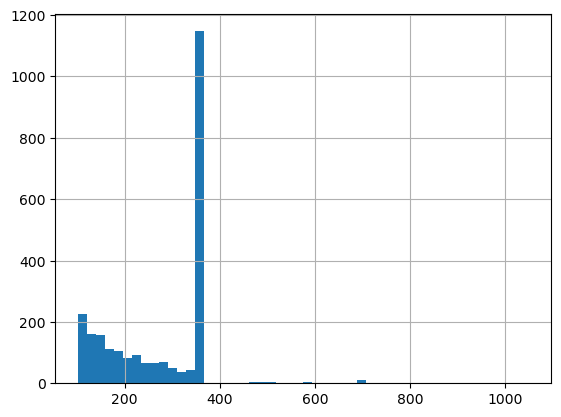

In [25]:
ds_df_label_vc.hist( bins = 50 )

Most classes have 350 datapoints because I *thought* I had downsampled the datasets with more than 350 datapoints down to 350 but it looks like there are some that were not affected by the transformation I performed. There are some classes with more than 350 datapoints somehow. Regardless, we will be downsampling them all to the lowest value_count (101)...

### Dataset Transformation
(downsample, upsample, etc.)

In [26]:
# Downsample to equal number of samples per class if downsample param is set
if ( run['dataset']['downsample'] ):
    # if downsample param is 'min', downsample all classes to the same number of
    # samples as the class with the least samples
    if ( run['dataset']['downsample'] == 'min' ):
        ds_df_label_vc_min = ds_df_label_vc.min()
        print('Downsampling to least number of samples per class: %d' % ds_df_label_vc_min)
    else:
        # manual override
        if ( run['dataset']['downsample'] > 0 ):
            print( 'Overriding samples per class to: %d' % run['dataset']['downsample'] )
            ds_df_label_vc_min = run['dataset']['downsample']
        else: raise Exception("dataset downsample invalid")
    
    # downsample based on 
    ds_df_trans = ds_df.groupby( by = datasets[ run['dataset']['source'] ].col_label ).sample( n = ds_df_label_vc_min )
    ds_df_trans[ datasets[ run['dataset']['source'] ].col_label ].value_counts()

Downsampling to least number of samples per class: 101


In [27]:
# verifying that our downsampling worked - all classes should have the same value_count
ds_df_trans[ datasets[ run['dataset']['source'] ].col_label ].value_counts().value_counts()

101    2451
Name: acceptedScientificName, dtype: int64

We have transformed the original dataset through downsampling to produce a dataset where all classes have the same number of datapoints as the class with the least amount of datapoints.

In [28]:
print( 'New datapoint count: %d' % len(ds_df_trans) )

New datapoint count: 247551


### Train, Validation, Test Split

In [29]:
run['dataset']['split_test'] = 0.05
run['dataset']['split_val'] = 0.1

In [30]:
# generate random states for reproducability
import random

# [0, 2**32 - 1]
run['dataset']['seed_split_test'] = random.randint( 0, 2**32 - 1 )
run['dataset']['seed_split_val'] = random.randint( 0, 2**32 - 1 )

In [31]:
# test
ds_df_train, ds_df_test = train_test_split(
    ds_df_trans,
    test_size = run['dataset']['split_test'],
    stratify = ds_df_trans[[ datasets[ run['dataset']['source'] ].col_label ]],
    random_state = run['dataset']['seed_split_test'],
)

# val
ds_df_train, ds_df_val = train_test_split(
    ds_df_train,
    test_size = run['dataset']['split_val'],
    stratify = ds_df_train[[ datasets[ run['dataset']['source'] ].col_label ]],
    random_state = run['dataset']['seed_split_val'],
)

### Input Data Pipeline Generation

In [32]:
def load_image(
    filename,
):
    img_raw = tf.io.read_file( filename )
    img_tensor = tf.image.decode_image(
        img_raw,
        dtype = tf.dtypes.float32,
        channels = 3,
        expand_animations = False,
    )
    return img_tensor

In [33]:
def resize(
    img_tensor,
    input_dim,
):
    return tf.image.resize(
        img_tensor,
        [ input_dim, input_dim ],
    )

In [34]:
def preprocessing(
    img_tensor,
    preprocessor,
):
    return preprocessor( img_tensor )

In [35]:
def my_label_encoder( label, mapping ):
    one_hot = label == mapping
    label_encoded = tf.argmax( one_hot )
    return label_encoded

In [36]:
def encode_label(
    label,
    label_encoder,
):
    return label_encoder( label )

In [37]:
def data_augmentation(
    img_tensor,
    augmentation_func,
):
    return augmentation_func( img_tensor, training = True )    

In [38]:
# Augmentation function selection
augmentation_functions = [
    tf.keras.Sequential( [
        tf.keras.layers.RandomFlip( "horizontal_and_vertical" ),
        tf.keras.layers.RandomRotation( 0.2 ),
    ] )
]

In [39]:
# set augmentation_func to None if no augmentation is desired
# augmentation_func = augmentation_functions[0]
augmentation_func = None

# Determines if data augmentation should be done in the IDP or in the model
# Data augmentation will
data_augmentation_in_ds = True

In [40]:
# use a buffersize equal to the length of the dataset
shuffle_buffer_size = int( len( ds_df_train ) )

In [41]:
# generate and save the shuffle random seed
run['dataset']['seed_shuffle'] = tf.random.uniform(
    shape = (),
    dtype = tf.int64,
    maxval = tf.int64.max,
).numpy()
# make it json serializable...
run['dataset']['seed_shuffle'] = int( run['dataset']['seed_shuffle'] )

In [42]:
# Determines if preprocessing should be done in the IDP or in the model
preprocessing_in_ds = True

In [43]:
# label encoding
# (img_tensor_resized_preprocessed, label_encoded)
label_encoder = tf.keras.layers.StringLookup(
    vocabulary = ds_classes,
    # sparse = True,
    output_mode = 'one_hot',
    num_oov_indices = 0,
)

def make_idp(
    filenames,
    labels,
    input_dim,
    is_training = False,
    batch_size = 32,
    augmentation_func = None,
):
    ds = tf.data.Dataset.from_tensor_slices( (
        filenames,
        labels,
    ) )

    # if isTraining, shuffle
    if ( is_training ):
        ds = ds.shuffle(
            buffer_size = shuffle_buffer_size,
            seed = run['dataset']['seed_shuffle'],
        )

    # image loading
    # (img_tensor, label)
    ds = ds.map(
        lambda filename, label: (
            load_image(filename),
            label,
        ),
        num_parallel_calls = AUTOTUNE,
    )

    # if isTraining and augmentation_func exists, use data augmentation
    if ( is_training and data_augmentation_in_ds and augmentation_func ):
        logging.info("Adding data augmentation.")
        ds = ds.map(
            lambda img_tensor, label: (
                data_augmentation(img_tensor, augmentation_func),
                label,
            ),
            num_parallel_calls = AUTOTUNE,
        )
    
    # image resizing
    # (img_tensor_resized, label)
    ds = ds.map(
        lambda img_tensor, label: (
            resize( img_tensor, input_dim ),
            label,
        ),
        num_parallel_calls = AUTOTUNE,
    )
    
    # image preprocessing
    # (img_tensor_resized_preprocessed, label)
    if ( preprocessing_in_ds ):
        ds = ds.map(
            lambda img_tensor_resized, label: (
                preprocessing( img_tensor_resized, base_models[ run['model']['base'] ].preprocessor ),
                label,
            ),
            num_parallel_calls = AUTOTUNE,
        )


    ds = ds.map(
        lambda img_tensor_resized_preprocessed, label: (
            img_tensor_resized_preprocessed,
            encode_label( label, label_encoder ),
            # encode_label( label, lambda x: my_label_encoder( x, ds_classes ) ),
        ),
        num_parallel_calls = AUTOTUNE,
    )

    # Batch
    ds = ds.batch( batch_size )
    
    # Prefetch
    ds = ds.prefetch( buffer_size = AUTOTUNE )
    
    return ds


/home/charlescoult/.conda/envs/fungi/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [44]:
# IDP creation
ds_idp_train = make_idp(
    ds_df_train[ datasets[ run['dataset']['source'] ].col_filename ].values,
    ds_df_train[ datasets[ run['dataset']['source'] ].col_label ].values,
    input_dim = base_models[ run['model']['base'] ].input_dim,
    is_training = True,
    batch_size = run['batch_size'],
    augmentation_func = augmentation_func if ( augmentation_func ) else None,
)

ds_idp_val = make_idp(
    ds_df_val[ datasets[ run['dataset']['source'] ].col_filename ].values,
    ds_df_val[ datasets[ run['dataset']['source'] ].col_label ].values,
    input_dim = base_models[ run['model']['base'] ].input_dim,
    is_training = False,
    batch_size = run['batch_size'],
    # turned off by is_training = False anyway...
    augmentation_func = None,
)

ds_idp_test = make_idp(
    ds_df_test[ datasets[ run['dataset']['source'] ].col_filename ].values,
    ds_df_test[ datasets[ run['dataset']['source'] ].col_label ].values,
    input_dim = base_models[ run['model']['base'] ].input_dim,
    is_training = False,
    batch_size = run['batch_size'],
    # turned off by is_training = False anyway...
    augmentation_func = None,
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


---

## Model Building

In [45]:
# return a name that accurately describes the model building function or
# the tfhub model (by url) that was passed
def get_model_name( model_handle ):

    if callable(model_handle):
        return f'keras.applications/{model_handle.__name__}'
    else:
        split = model_handle.split('/')
        return f'tfhub/{split[-5]}.{split[-4]}.{split[-3]}'
    

In [46]:
# Initialize full model
with strategy.scope():
    full_model = tf.keras.Sequential( name = "full_model" )

In [47]:
# if preprocessing_in_ds, then input is assumed to be preprocessed correctly from input dataset pipeline (idp)
# else, add preprocessing layer to model
with strategy.scope():
    if ( not preprocessing_in_ds ):
        raise Exception('not yet implemented')
        full_model.add(

        )

In [48]:
# generate base_model layer
def gen_base_model_layer(
    name,
    source,
    input_dim,
    trainable = False,
):
    # If model_handle is a model building function, use that function
    if callable( source ):
        base_model = source(
            include_top = False,
            input_shape = ( input_dim, input_dim ) + (3,),
            weights = 'imagenet',
            # pooling = 'avg',
        )

    # otherwise build a layer from the tfhub url that was passed as a string
    else:
        base_model = hub.KerasLayer(
            source,
            input_shape = ( input_dim, input_dim ) + (3,),
            name = name,
        )
    
    base_model.trainable = trainable

    return base_model


In [49]:
# Add base model to full_model
with strategy.scope():
    full_model.add( gen_base_model_layer(
        name = get_model_name( base_models[ run['model']['base'] ].source ),
        source = base_models[ run['model']['base'] ].source,
        input_dim = base_models[ run['model']['base'] ].input_dim,
        trainable = True,
    ) )

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [50]:
# generate classifier
def gen_classifier_model_layer(
    num_classes,
    dropout,
    add_softmax = False,
):
    model = tf.keras.Sequential()
    model.add(
        layers.Dense(
            num_classes,
            # activation = 'softmax',
        )
    )

    model.add(
        layers.Dropout(dropout),
    )

    if ( add_softmax ):
        model.add(
            layers.Activation("softmax", dtype="float32"),
        )

    return model

In [51]:
run['model']['classifier']['output_logits'] = True
# Add classifier model to full_model
# TODO allow selection between different classification models
with strategy.scope():
    full_model.add( gen_classifier_model_layer(
        num_classes = len( ds_classes ),
        dropout = run['model']['classifier']['dropout'],
        add_softmax = not run['model']['classifier']['output_logits'],
    ) )

---

* Note regarding `thawed_base_model_layers` and full model architecture ([reference](https://stackoverflow.com/questions/64227483/what-is-the-right-way-to-gradually-unfreeze-layers-in-neural-network-while-learn))
![image](https://i.stack.imgur.com/JLJqv.png)
* [Another great reference](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)

---

# Training Run

In [52]:
# TODO: allow loading of model weights from previous run
load_weights = None

In [53]:
# Compile model
# Sparse vs non-sparse CCE https://www.kaggle.com/general/197993
with strategy.scope():
    full_model.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate = run['model']['learning_rate']
        ),
        # loss = tf.keras.losses.SparseCategoricalCrossentropy(
        #     from_logits = True,
        # ),
        loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits = run['model']['classifier']['output_logits'],
            label_smoothing = run['label_smoothing'],
        ),
        metrics = [
            'accuracy',
            tf.keras.metrics.AUC(),
            # tf.keras.metrics.SparseCategoricalCrossentropy(),
            # tf.keras.metrics.SparseTopKCategoricalAccuracy(
            #     k = 3,
            #     name = "Top3",
            # ),
            # tf.keras.metrics.SparseTopKCategoricalAccuracy(
            #     k = 10,
            #     name="Top10",
            # ),
            # tf.keras.metrics.CategoricalCrossentropy(),            
            # tf.keras.metrics.TopKCategoricalAccuracy( k=3, name="Top3" ),
            # tf.keras.metrics.TopKCategoricalAccuracy( k=10, name="Top10" ),
        ],
    )

In [54]:
# Tensorboard logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = run['path'],
    histogram_freq = 1,
)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    # monitor='val_sparse_categorical_accuracy',
    monitor = run['callbacks']['early_stopping']['monitor'],
    verbose = 1,
    patience = run['callbacks']['early_stopping']['patience'],
    # min_delta = 0.01, # defaults to 0.
    restore_best_weights = run['callbacks']['early_stopping']['restore_best_weights'],
    start_from_epoch = run['callbacks']['early_stopping']['start_from_epoch'],
    # mode = 'min', # should be chosen correctly based on monitor value
)

# Model Checkpoints for saving best model weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join( run['path'], 'best_model' ),
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1,
    # mode = 'min', # should be chosen correctly based on monitor value
)

class TimeCallback( tf.keras.callbacks.Callback ):
    
    def __init__(
        self,
        metric_name = 'epoch_duration',
    ):
        self.__epoch_start = None
        self.__metric_name = metric_name
    
    def on_epoch_begin(
        self,
        epoch,
        logs = None,
    ):
        self.__epoch_start = datetime.datetime.utcnow()
        
    def on_epoch_end(
    ):
        logs[ self.__metric_name ] = datetime.datetime.utcnow() - self.__epoch_start


callbacks = [
    tensorboard_callback,
    early_stopping_callback,
    model_checkpoint_callback,
]

In [55]:
print_run_metadata( run )

{
   "id": "2023_03_19-16_34_48",
   "notebook_ver": "0.0.1",
   "path": "/media/data/runs/2023_03_19-16_34_48",
   "batch_size": 128,
   "max_epochs": 20,
   "label_smoothing": 0.1,
   "model": {
      "learning_rate": 0.0005,
      "classifier": {
         "dropout": 0.33,
         "output_logits": true
      },
      "base": "Inception_v3_iNaturalist"
   },
   "dataset": {
      "downsample": "min",
      "source": "gbif",
      "split_test": 0.05,
      "split_val": 0.1,
      "seed_split_test": 1456402203,
      "seed_split_val": 2341142523,
      "seed_shuffle": 951075912142645497
   },
   "callbacks": {
      "early_stopping": {
         "restore_best_weights": true
      }
   },
   "label_mapping_path": "/media/data/runs/2023_03_19-16_34_48/label_mapping.json"
}


In [56]:
save_run_metadata( run )

In [57]:
# Train
timer['train_start'] = time.perf_counter()

try:
    with strategy.scope():
        history = full_model.fit(
            ds_idp_train,
            validation_data = ds_idp_val,
            epochs = run['max_epochs'],
            callbacks = callbacks,
            # validation_freq=2,
        )
except KeyboardInterrupt:
    print('\n\nInterrupted...')
    # run['interrupted'] = True
else:
    print('Completed.')
    # run['interrupted'] = False
    
timer['train_end'] = time.perf_counter()


Epoch 1/20
1654/1654 [==============================] - ETA: 0s - loss: 7.8494 - accuracy: 0.0010 - auc: 0.5578
Epoch 1: val_loss improved from inf to 9.52973, saving model to /media/data/runs/2023_03_19-16_34_48/best_model


1654/1654 [==============================] - 1450s 854ms/step - loss: 7.8494 - accuracy: 0.0010 - auc: 0.5578 - val_loss: 9.5297 - val_accuracy: 4.2521e-04 - val_auc: 0.5000
Epoch 2/20
1654/1654 [==============================] - ETA: 0s - loss: 7.4985 - accuracy: 0.0033 - auc: 0.6618
Epoch 2: val_loss did not improve from 9.52973
1654/1654 [==============================] - 1540s 931ms/step - loss: 7.4985 - accuracy: 0.0033 - auc: 0.6618 - val_loss: 40.1899 - val_accuracy: 3.8269e-04 - val_auc: 0.5003
Epoch 3/20
1654/1654 [==============================] - ETA: 0s - loss: 7.2587 - accuracy: 0.0085 - auc: 0.7172
Epoch 3: val_loss improved from 9.52973 to 8.00553, saving model to /media/data/runs/2023_03_19-16_34_48/best_model


1654/1654 [==============================] - 1464s 885ms/step - loss: 7.2587 - accuracy: 0.0085 - auc: 0.7172 - val_loss: 8.0055 - val_accuracy: 4.6773e-04 - val_auc: 0.5050
Epoch 4/20
1654/1654 [==============================] - ETA: 0s - loss: 6.9979 - accuracy: 0.0203 - auc: 0.7499
Epoch 4: val_loss did not improve from 8.00553
1654/1654 [==============================] - 1450s 877ms/step - loss: 6.9979 - accuracy: 0.0203 - auc: 0.7499 - val_loss: 8.0780 - val_accuracy: 3.8269e-04 - val_auc: 0.5000
Epoch 5/20
1654/1654 [==============================] - ETA: 0s - loss: 6.7620 - accuracy: 0.0370 - auc: 0.7683
Epoch 5: val_loss did not improve from 8.00553
1654/1654 [==============================] - 1466s 886ms/step - loss: 6.7620 - accuracy: 0.0370 - auc: 0.7683 - val_loss: 8.2458 - val_accuracy: 3.8269e-04 - val_auc: 0.4981
Epoch 6/20
1654/1654 [==============================] - ETA: 0s - loss: 6.4970 - accuracy: 0.0634 - auc: 0.7834
Epoch 6: val_loss did not improve from 8.00553
1

In [58]:
run['time'] = timer['train_end'] - timer['train_start']
print(run['time'])

10756.124112295


In [59]:
save_run_metadata( run )

/tmp/ipykernel_12476/3436063570.py:32: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['notebook_ver', 'path', 'model.classifier.output_logits', 'model.base',
       'dataset.downsample', 'dataset.source', 'label_mapping_path',
       'model.classifier.output_normalize',
       'callbacks.early_stopping.monitor'],
      dtype='object')]

  runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


In [60]:
print_run_metadata( run )

{
   "id": "2023_03_19-16_34_48",
   "notebook_ver": "0.0.1",
   "path": "/media/data/runs/2023_03_19-16_34_48",
   "batch_size": 128,
   "max_epochs": 20,
   "label_smoothing": 0.1,
   "model": {
      "learning_rate": 0.0005,
      "classifier": {
         "dropout": 0.33,
         "output_logits": true
      },
      "base": "Inception_v3_iNaturalist"
   },
   "dataset": {
      "downsample": "min",
      "source": "gbif",
      "split_test": 0.05,
      "split_val": 0.1,
      "seed_split_test": 1456402203,
      "seed_split_val": 2341142523,
      "seed_shuffle": 951075912142645497
   },
   "callbacks": {
      "early_stopping": {
         "restore_best_weights": true
      }
   },
   "label_mapping_path": "/media/data/runs/2023_03_19-16_34_48/label_mapping.json",
   "time": 10756.124112295
}


In [61]:
len( history.epoch )

NameError: name 'history' is not defined

## Testing

In [ ]:
test_labels = np.concatenate([y for x, y in ds_idp_test], axis=0)

In [ ]:
with strategy.scope():
    predictions = full_model.predict(
        ds_idp_test,
    )
    

In [ ]:
predictions

In [ ]:
predictions.shape

In [ ]:
predictions.min()

In [ ]:
predictions.max()

In [ ]:
test_labels

In [ ]:
test_labels.shape

In [ ]:
test_labels.min()

In [ ]:
test_labels.max()

In [ ]:
np.argmax( predictions, axis=1)

In [ ]:
np.argmax( test_labels, axis = 1)

In [ ]:
cm = tf.math.confusion_matrix(
    np.argmax( test_labels, axis=1),
    np.argmax( predictions, axis=1),
)

In [ ]:
import sklearn
sklearn.metrics.f1_score(
    np.argmax( test_labels, axis = 1 ),
    np.argmax( predictions, axis = 1 ),
    average = 'micro',
)
